In [1]:
# magic command for automatic reload of python modules without needing to restart the notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import math as m
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
import utils as utl
import scipy as sc
from collections import OrderedDict
# importing NN library
import torch as tr
import torch.nn as nn
# importing torch distributions and transformations 
import torch.distributions as trd
import torch.distributions.transforms as trt
from models import ConditionalExpenseModel
from sklearn import preprocessing

In [3]:
#Reading data
df_trn = pd.read_csv('Predictive_Expenses_DATA/train.csv')
df_tst = pd.read_csv('Predictive_Expenses_DATA/test.csv')

# Preprocess the data
df_trn = utl.preProcess(df_trn)
df_tst = utl.preProcess(df_tst)

In [4]:
# Further splittling the training dataset into training and validation
# first, shuffling training dataset before splitting (sample with fraction =1 shuffles all the rows)
df_trn=df_trn.sample(frac=1)
n_trn = int(len(df_trn)*0.75)
# then, splitting
df_vld=df_trn.iloc[n_trn:,:]
df_trn=df_trn.iloc[:n_trn,:]

print(f' Train Data Size: {len(df_trn)}, Validation Data Size: {len(df_vld)} Test Data Size: {len(df_tst)}')

 Train Data Size: 555666, Validation Data Size: 185222 Test Data Size: 185469


In [5]:
# Specifying the target and covariates for regression
target = 'log_expense'
covariates=df_trn.columns.to_list()
to_remove=['id','wi','income','expense','wts','log_expense']
covariates = [var for var in covariates if var not in to_remove]
print(f'\033[1m Covariates:\033[0m {covariates}')
print(f'\033[1m Target: \033[0m{target}')

 Covariates: ['year', 'month', 'age', 'education', 'familysize', 'urban', 'race', 'region', 'state', 'marital', 'occupation', 'log_income']
 Target: log_expense


 Covariates: ['age', 'education', 'familysize', 'marital', 'occupation', 'log_income']


C:\Users\tewar\Anaconda3\envs\pythonEnvPyTorch\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


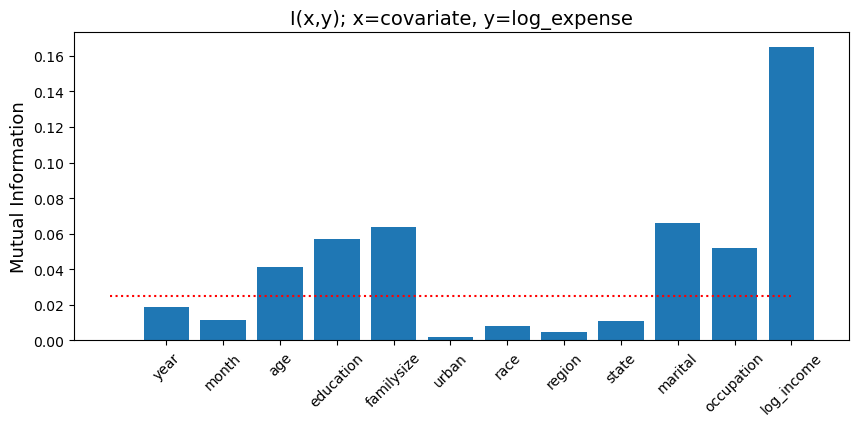

In [6]:
# Assessing Information Content (about the target) of the covariates via Mutual infromation (MI)
mutual_info={}
y = utl.discretize(df_trn[target],20) # target variable (discretizing it for MI calculation)
for var in covariates:
    x=df_trn[var].to_numpy()
    x=utl.discretize(x,20)
    mutual_info[var]=mutual_info_score(x,y)
    
MI_threshold=0.025 # Thrshold for mutual Information
# plotting MI
plt.figure(figsize=(10,4))
plt.bar(list(mutual_info.keys()), list(mutual_info.values()));
plt.plot(np.arange(-1,len(covariates)),np.array([MI_threshold]*(len(covariates)+1)),'r:')
ax=plt.gca();
ax.set_xticklabels(list(mutual_info.keys()), rotation = 45);
plt.ylabel('Mutual Information',fontsize=13)
plt.title('I(x,y); x=covariate, y=log_expense',fontsize=14)

# Keeping only those covariate with MI above the specified threshold
covariates=[var for var in covariates if mutual_info[var]>MI_threshold]
print(f'\033[1m Covariates:\033[0m {covariates}')


In [7]:
# Defining the Covariate Type (Categorical, Numeric). Ordinal Variable (eduction) is considered Numeric here.
covariates_categorical = ['marital','occupation']
covariates_numeric = [var for var in covariates if var not in covariates_categorical]
print(f'\033[1m Categorical Covariates: \033[0m {covariates_categorical}')
print(f'\033[1m Numerical Covariates: \033[0m {covariates_numeric}')

 Categorical Covariates:  ['marital', 'occupation']
 Numerical Covariates:  ['age', 'education', 'familysize', 'log_income']


In [8]:
# Standardizing Numerical covariates
standard_transforms={}
for var in covariates_numeric+[target]:
    # estimate loc and scale w.r.t to training dataset
    standardize = preprocessing.StandardScaler().fit(df_trn[var].to_numpy().reshape(-1,1))
    df_trn[var]=standardize.transform(df_trn[var].to_numpy().reshape(-1,1))
    # also standardize the validation and test datasets
    df_vld[var]=standardize.transform(df_vld[var].to_numpy().reshape(-1,1))
    if var in df_tst:
        df_tst[var]=standardize.transform(df_tst[var].to_numpy().reshape(-1,1))
    standard_transforms[var]=standardize

In [9]:
# Hot encoding the categorical variables for all datasets (the hot encoded data is saved as sparse matrices)
hot_encoded_data_trn, num_categories=utl.hotEncodeData(df_trn,covariates_categorical)
hot_encoded_data_vld,_=utl.hotEncodeData(df_vld,covariates_categorical)
hot_encoded_data_tst,_=utl.hotEncodeData(df_vld,covariates_categorical)

In [10]:
# Defining train step
def train_step(model,row_ids):
    model.train()
    x_batch, y_batch, w_batch = utl.getBatch(df_trn, 
                                    hot_encoded_data_trn, 
                                    row_ids, 
                                    covariates_categorical, 
                                    covariates_numeric,
                                    target,
                                    scaled_weights=False)
            
    x_batch, y_batch, w_batch = map(tr.FloatTensor,(x_batch,y_batch, w_batch))        
    mu,log_sig=model.forward(x_batch)
    y_dist=trd.Normal(loc=mu.view(-1,1),scale=tr.exp(log_sig.view(-1,1)))        
    loss,_= utl.pinballLoss(y_dist, y_batch, w_batch)  
    return loss

# Defining validation step
def valid_step(model,row_ids):
    model.eval()
    x_batch, y_batch, w_batch = utl.getBatch(df_vld, 
                                    hot_encoded_data_vld, 
                                    row_ids, 
                                    covariates_categorical, 
                                    covariates_numeric,
                                    target,
                                    scaled_weights=False)
    x_batch, y_batch, w_batch = map(tr.FloatTensor,(x_batch,y_batch, w_batch))
    with tr.no_grad(): 
        mu,log_sig=model.forward(x_batch)
        y_dist=trd.Normal(loc=mu.view(-1,1),scale=tr.exp(log_sig.view(-1,1)))        
        loss,_= utl.pinballLoss(y_dist, y_batch, w_batch) 
    return loss    

# Defining t
def fit(model, epochs=10, batch_size_train=100, batch_size_valid=500, lr=1E-3, print_every=100):
    optimizer = tr.optim.Adam(model.parameters(),lr=lr)
    n_train = len(df_trn)
    n_valid = len(df_vld)
    n_iters = n_train//batch_size_train+1
    loss_train,loss_valid=[],[]
          
    for epoch in range(epochs):           
        # Training 
        for itr in range(n_iters):
            st,en=itr*batch_size_train, min(n_train,(itr+1)*batch_size_train)
            row_ids = list(range(st,en))         
            trn_loss = train_step(model,row_ids)          
            trn_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            if itr%print_every==0:
                # Validation Step
                row_ids = np.random.choice(n_valid,batch_size_valid,replace=False).tolist()
                vld_loss = valid_step(model,row_ids)
#                 # rounding losses
#                 trn_loss=np.round(float(trn_loss.data)*(n_train/batch_size_train),3)
#                 vld_loss=np.round(float(vld_loss.data)*(n_valid/batch_size_valid),3)                
                trn_loss=np.round(float(trn_loss.data),2)
                vld_loss=np.round(float(vld_loss.data),2)
                
                
                print(f'Epoch: {epoch}, Iter: {itr}, Train Loss: {trn_loss}, Valid Loss: {vld_loss}')
                loss_train.append(trn_loss)
                loss_valid.append(vld_loss)
    return loss_train, loss_valid
    
        

In [11]:
# Instantiating the DNN based conditional density model for the target i.e. p(y|X)
input_dim = sum(num_categories.values())+len(covariates_numeric)
layers = [input_dim, input_dim//2, input_dim//4]
exp_model=ConditionalExpenseModel(input_dim,layers)

In [ ]:
loss_train, loss_valid=fit(exp_model,batch_size_train=50,epochs=4)

Epoch: 0, Iter: 0, Train Loss: 213.05, Valid Loss: 275.81
Epoch: 0, Iter: 100, Train Loss: 203.46, Valid Loss: 304.94
Epoch: 0, Iter: 200, Train Loss: 229.83, Valid Loss: 204.74
Epoch: 0, Iter: 300, Train Loss: 80.71, Valid Loss: 297.3
Epoch: 0, Iter: 400, Train Loss: 444.79, Valid Loss: 165.46
Epoch: 0, Iter: 500, Train Loss: 198.68, Valid Loss: 148.15
Epoch: 0, Iter: 600, Train Loss: 582.32, Valid Loss: 252.85
Epoch: 0, Iter: 700, Train Loss: 197.61, Valid Loss: 226.77
Epoch: 0, Iter: 800, Train Loss: 249.8, Valid Loss: 314.92
Epoch: 0, Iter: 900, Train Loss: 286.39, Valid Loss: 219.41
Epoch: 0, Iter: 1000, Train Loss: 96.17, Valid Loss: 194.58
Epoch: 0, Iter: 1100, Train Loss: 309.44, Valid Loss: 275.19
Epoch: 0, Iter: 1200, Train Loss: 238.66, Valid Loss: 191.75
Epoch: 0, Iter: 1300, Train Loss: 197.44, Valid Loss: 161.45
Epoch: 0, Iter: 1400, Train Loss: 248.59, Valid Loss: 173.64
Epoch: 0, Iter: 1500, Train Loss: 258.78, Valid Loss: 199.95
Epoch: 0, Iter: 1600, Train Loss: 284.97

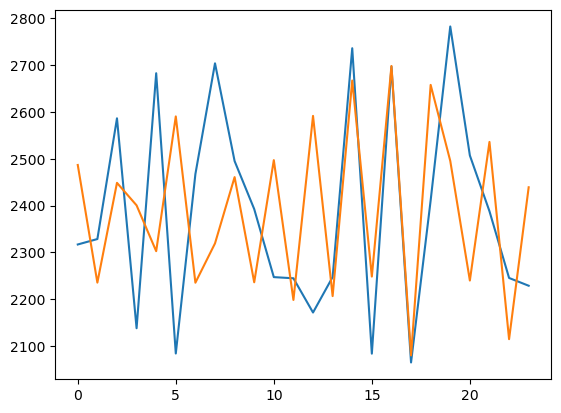

In [360]:
plt.plot(loss_train)
plt.plot(loss_valid)

In [361]:
exp_model.eval()
row_ids = np.random.choice(len(df_vld),1000,replace=False).tolist()
x_batch,y_batch, w_batch = utl.getBatch(df_vld, 
                       hot_encoded_data_vld,
                       row_ids,
                       covariates_categorical,
                       covariates_numeric,
                       target)
x_batch, y_batch, w_batch = map(tr.FloatTensor,(x_batch,y_batch, w_batch))

with tr.no_grad(): 
    mu,log_sig=exp_model.forward(x_batch)
y_dist=trd.Normal(loc=mu.view(-1,1),scale=tr.exp(log_sig.view(-1,1)))        

In [346]:
multipliers=[0.0001,0.001, 0.01, 0.05, 0.1, 1, 2,10]
loss_mle=[]
loss_pbl=[]
for m in multipliers:
    y_dist=trd.Normal(loc=mu.view(-1,1),scale=tr.exp(log_sig.view(-1,1))*m)        
    loss_mle.append(float(utl.MLE_loss(y_dist,y_batch,w_batch)))
    l,_=utl.pinballLoss(y_dist,y_batch,w_batch)
    loss_pbl.append(float(l))

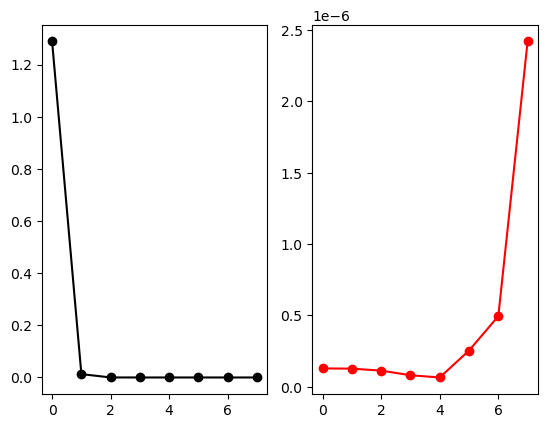

In [347]:
plt.subplot(121)
plt.plot(loss_mle,'ko-')
plt.subplot(122)
plt.plot(loss_pbl,'ro-')

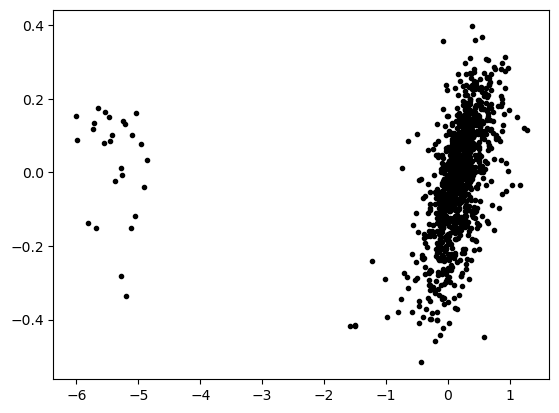

In [362]:
plt.plot(y_batch.squeeze(-1),mu,'k.')
# plt.xlim(3,10)
# plt.ylim(3,10)

In [296]:
exp_model.eval()
row_ids = np.random.choice(len(df_vld),1,replace=False).tolist()
x_batch,y_batch, w_batch = utl.getBatch(df_vld, 
                       hot_encoded_data_vld,
                       row_ids,
                       covariates_categorical,
                       covariates_numeric,
                       target)
x_batch, y_batch, w_batch = map(tr.FloatTensor,(x_batch,y_batch, w_batch))
with tr.no_grad(): 
    mu,log_sig=exp_model.forward(x_batch)
y_dist=trd.Normal(loc=mu.view(-1,1),scale=tr.exp(log_sig.view(-1,1)))        
loss,_= utl.pinballLoss(y_dist,y_batch,w_batch) 

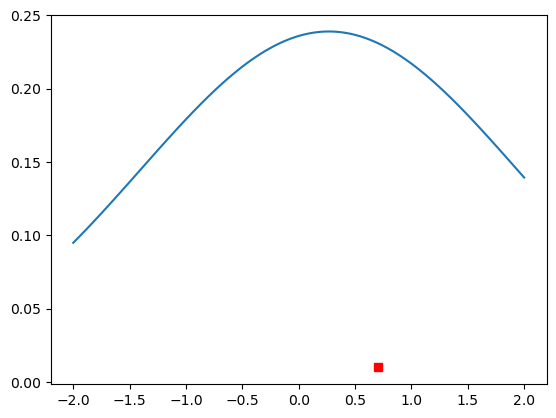

In [297]:
y_g=tr.FloatTensor(np.linspace(-2,2,100))
y_lp=y_dist.log_prob(y_g)
plt.plot(y_g,tr.exp(y_lp.squeeze()))
plt.plot(y_batch,0.01,'rs')

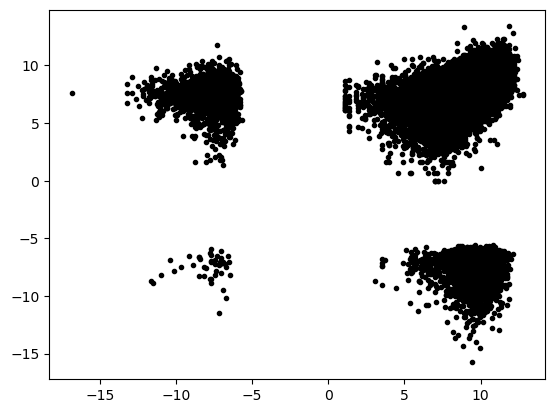

In [201]:
plt.plot(df_vld['log_income'],df_vld['log_expense'],'k.')


In [ ]:
df_trn['zero_expense']=df_trn['expense']
df_trn.head()
df_trn['zero_expense']=df_trn['zero_expense'].apply(lambda x: 0 if x>1 else 1)
covariates=df_trn.columns.to_list()
for var in ['id','income','expense','zero_expense','log_expense']:
    covariates.remove(var)
# Approximating the mutual information between the target (log_expense) and the covariates
mutual_info={}
y = df_trn['zero_expense'].to_numpy() # response variable
for var in covariates:
    x=df_trn[var].to_numpy()
    x=utl.discretize(x,20)
    mutual_info[var]=mutual_info_score(x,y)
plt.figure(figsize=(10,4))
plt.bar(list(mutual_info.keys()), list(mutual_info.values()));
ax=plt.gca();
ax.set_xticklabels(list(mutual_info.keys()), rotation = 45);
plt.ylabel('Mutual Information',fontsize=13)
plt.title('I(x,y); x=covariate, y=log_expense',fontsize=14)

# dfff=df_trn.loc[df_trn['zero_expense']==0]
# arr=dfff['month'].to_numpy()
# from collections import Counter
# c=Counter(arr)
# items = c.keys()
# counts= c.values()
# plt.bar(items, counts)


In [ ]:
total=sum(df_trn['wi'])
df_trn['wts']=df_trn['wi']/total

In [ ]:
df_trn

In [ ]:
1057/total

In [ ]:
df_trn['wts'].to_numpy()[-1]